In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
import gc
import sys
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import seaborn as sns
import pandas.core.indexes as i
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape
from tensorflow.keras.layers import Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
import keras
from keras import layers



In [ ]:
import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

np.random.seed(237)

In [ ]:
# let's prepare our input data. We are using MNIST digits and we are disregrading the labels (since we are only interested in encoding/decoding the input images)
# load the data
copied_path='/content/drive/MyDrive/9z_ML_Bootcamp/Wafer_Defects/1LSWMD.pkl'
data=pd.read_pickle(copied_path)



In [ ]:
data_backup=data
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
# if need restart, restart from here. reading data took too long
resize_img=28
RGB=1


data=data_backup
data=shuffle(data)




In [ ]:
# remove the [] in failure type. easier for onehot encoder
label=data.trianTestLabel.values
label = [ str(obj).replace("[[", "").replace("]]", "") for obj in label ]
label = np.array(label)
len(label)

811457

In [ ]:
failuretype=data.failureType.values
failuretype = [ str(obj).replace("[['", "").replace("']]", "") for obj in failuretype ]
failuretype = np.array(failuretype)
len(failuretype)

811457

In [ ]:
df=pd.DataFrame()
df['label']=label
df['type']=failuretype
df['wafermap']=data.waferMap.values
df['diesize']=data['dieSize'].values
df['lot']=data.lotName.values
df['waferindex']=data.waferIndex
df.drop(df[df['type']=='[]'].index,axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172950 entries, 16 to 811454
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   label       172950 non-null  object 
 1   type        172950 non-null  object 
 2   wafermap    172950 non-null  object 
 3   diesize     172950 non-null  float64
 4   lot         172950 non-null  object 
 5   waferindex  172950 non-null  float64
dtypes: float64(2), object(4)
memory usage: 9.2+ MB


In [ ]:
types=df['type'].unique()
types

array(['none', 'Edge-Ring', 'Loc', 'Center', 'Edge-Loc', 'Random',
       'Scratch', 'Donut', 'Near-full'], dtype=object)

In [ ]:
# downsample 
imgs=df[df.type != 'none']['wafermap']
label=df[df.type != 'none']['type']

len(imgs.to_numpy())
label

95        Edge-Ring
136             Loc
152          Center
158        Edge-Loc
159       Edge-Ring
            ...    
811248       Center
811297       Random
811318       Center
811355    Edge-Ring
811439       Random
Name: type, Length: 25519, dtype: object

In [ ]:
none_sample=shuffle(df[df.type == 'none'])

none_downsample=df[df.type == 'none'].iloc[1:len(imgs.to_numpy())//3,:]
imgs_none= none_downsample.wafermap
label_none=none_downsample.type
len(imgs_none)

8505

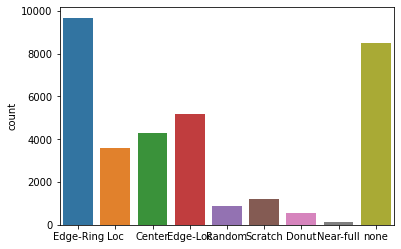

In [ ]:
x=imgs.append(imgs_none).to_numpy()
y=label.append(label_none).to_numpy()
len(y)
sns.countplot(y)

In [ ]:
# downsample, sample too large to fit
batch_fit=pd.DataFrame({'x':x,'y':y})
batch_fit=shuffle(batch_fit)
#batch_fit= batch_fit.iloc[1:20000,:]
x_map=batch_fit['x']
y=batch_fit['y']
batch_fit.shape

(34024, 2)

In [ ]:
# resize, the dimension of wafer maps are different. 
# need to resize to 1 dimenions. 
x_map=np.array([cv2.resize(img,dsize=(resize_img,resize_img),interpolation=cv2.INTER_CUBIC) for img in x_map])
xmap=x_map/2

In [ ]:
xmap_reshape=xmap.reshape((xmap.shape[0], resize_img*resize_img))

In [ ]:
def gray_rgb(X_data):
    X=[]

    for i in range(X_data.shape[0]):
        X_temp=X_data[i,:].reshape(resize_img,resize_img,1)
        X_temp_resize= tf.image.resize(X_temp, [resize_img,resize_img])
        X.append(np.concatenate((X_temp_resize,X_temp_resize,X_temp_resize),axis=-1))
    return X

In [ ]:
if RGB==3:
  xmap_reshape=np.asarray(gray_rgb(xmap_reshape))


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(xmap.reshape(-1,28,28,1), y, test_size=0.2, random_state=101)


In [ ]:

x_train=x_train[1:4000][:][:][:]
x_test=x_test[1:2000][:][:][:]
y_train=y_train[1:4000]
y_test=y_test[1:2000]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

(3999, 28, 28, 1)
(1999, 28, 28, 1)
(3999,)
3999 1999
3999 1999


In [ ]:
y_train_backup=y_train
y_test_backup=y_test

In [ ]:
y_train=y_train_backup
y_test=y_test_backup

In [ ]:
y_test

1243           Loc
16799       Center
19580    Edge-Ring
712      Edge-Ring
13741     Edge-Loc
           ...    
3027     Edge-Ring
8927       Scratch
30954         none
9319        Center
5252        Center
Name: y, Length: 1999, dtype: object

In [ ]:
n_classes=y.unique()
for i, j in enumerate(n_classes):
  y_train[y_train==j]=i
  y_test[y_test==j]=i

In [ ]:
y_test

19580    1
712      1
13741    3
11961    1
23663    2
        ..
3027     1
8927     0
30954    6
9319     2
5252     2
Name: y, Length: 1997, dtype: object

In [ ]:
y_test

19580    Edge-Ring
712      Edge-Ring
13741     Edge-Loc
11961    Edge-Ring
23663       Center
           ...    
3027     Edge-Ring
8927       Scratch
30954         none
9319        Center
5252        Center
Name: y, Length: 1997, dtype: object

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

def make_and_fit():
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2, activation='relu')(x)

    encoder = Model(inputs=inputs, outputs=encoded)
    
    encoded_inputs = Input(shape=(2,))

    x = Dense(4, activation='relu')(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
    x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)
    
    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    optimizer=Adam(learning_rate=0.001, beta_1=0.9,beta_2= 0.999)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    print(model.summary())
    
    clr = ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

    model.fit(
        x_train,
        x_train,
        batch_size=256,
        epochs=30,
        shuffle=True,
        validation_data=(x_test, x_test),
        callbacks=[clr])

    return model, encoder, decoder

model, encoder, decoder = make_and_fit()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_14 (Functional)        (None, 2)                 34889     
_________________________________________________________________
model_15 (Functional)        (None, 28, 28, 1)         42417     
Total params: 77,306
Trainable params: 77,082
Non-trainable params: 224
_________________________________________________________________
None
Epoch 1/30
16/16 [==============================] - 39s 2s/step - loss: 0.6690 - accuracy: 0.2424 - mse: 0.0762 - val_loss: 0.6927 - val_accuracy: 0.2153 - val_mse: 0.0860
Epoch 2/30
16/16 [==============================] - 37s 2s/step - loss: 0.5693 - accuracy: 0.3175 - mse: 0.0384 - val_loss: 0.6932 - val_accuracy: 0.1820 - val_mse: 0.0863
Epoch 3/30
16/16 [===============

In [ ]:
y_test
y_test = y_test.reset_index(drop=True)
print(y.unique())

['Scratch' 'Edge-Ring' 'Center' 'Edge-Loc' 'Random' 'Loc' 'none' 'Donut'
 'Near-full']


In [ ]:
labeldict={'Scratch':0, 'Edge-Ring':1, 'Center':2, 'Edge-Loc':3, 'Random':4, 'Loc':5, 'none':6, 'Donut':7,
 'Near-full':8}

(1999, 2)


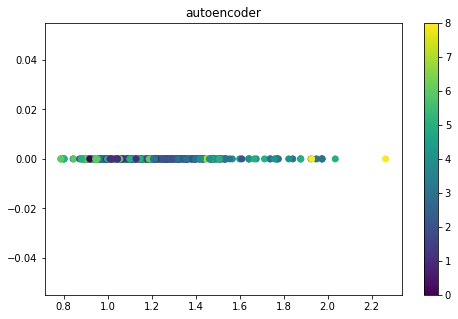

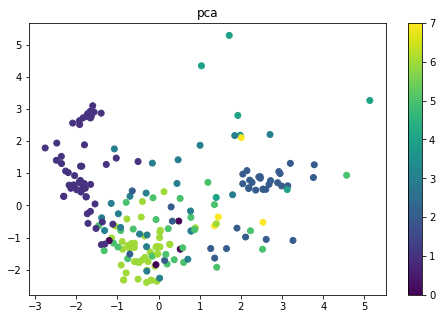

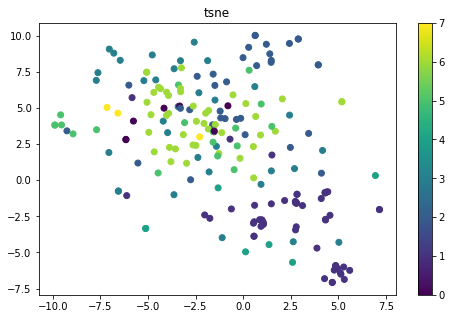

(300, 2)


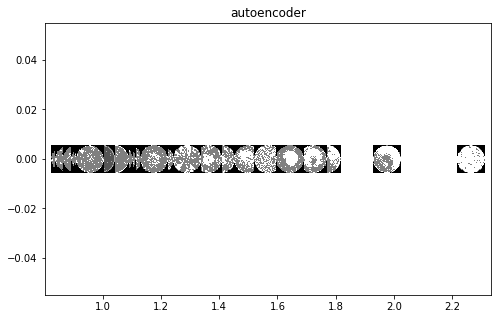

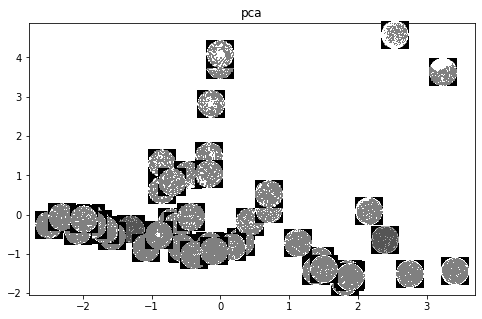

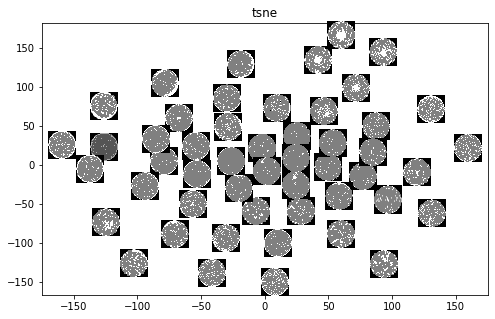

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
        print(coords.shape)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()

    plt.show()


plot_latent('dots', 1999, 'autoencoder')
plot_latent('dots', 200, 'pca')
plot_latent('dots', 200, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 50, 'pca')
plot_latent('imgs', 50, 'tsne')

NameError: ignored

ValueError: ignored

In [ ]:
x_test.shape

(1999, 28, 28, 1)

In [ ]:
coords.shape

(1999, 2)

In [ ]:
idx = np.random.choice(len(x_test), 200)
inputs = x_test[idx]
coords = TSNE(n_components=2).fit_transform(inputs.reshape(200, -1))

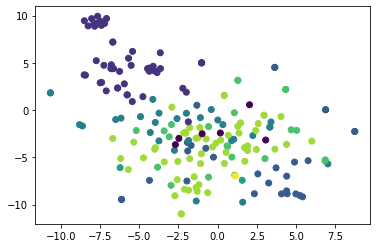

In [ ]:
classes = y_test2[idx]
        
plt.scatter(coords[:, 0], coords[:, 1], c=classes)

In [ ]:
y_test
y_test2 = y_test.reset_index(drop=True)

In [ ]:
y_test2

0       5
1       2
2       1
3       1
4       3
       ..
1994    1
1995    0
1996    6
1997    2
1998    2
Name: y, Length: 1999, dtype: object